In [1]:
from io import BytesIO

import boto3
from botocore import UNSIGNED
from botocore.config import Config
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.manifold import locally_linear_embedding
from sklearn.metrics import silhouette_score

SEED = 42

pd.set_option("display.max_columns", None)

In [ ]:
# Read and process labels file
labels = pd.read_csv(
    "../../data/_test_gz_decals_auto_posteriors_cropped_high_confidence.csv"
)

labels = labels[
    [
        "iauname",
        "smooth-or-featured_smooth_fraction",
        "smooth-or-featured_featured-or-disk_fraction",
        "smooth-or-featured_artifact_fraction",
    ]
]

labels.columns = ["iauname", "smooth", "featured", "artifact"]

labels["label"] = labels.values[:, 1:].argmax(axis=1)

labels.head()

,iauname,smooth,featured,artifact,label
0,J094329.86-003631.5,0.023483,0.945859,0.030658,1
1,J094052.50+000849.3,0.016835,0.952286,0.030879,1
2,J095249.26+010322.1,0.018752,0.949832,0.031416,1
3,J095303.76-005736.9,0.908406,0.037016,0.054578,0
4,J095609.04+011512.9,0.024842,0.949974,0.025184,1


In [3]:
labels["label"].value_counts()

label
1    1115
0     705
2     638
Name: count, dtype: int64

In [4]:
all_labels = labels["label"].unique()

IMAGES_PER_LABEL = 400

files_for_each_label = dict()

for label in all_labels:
    files_for_each_label[label] = labels[labels["label"] == label].iloc[:400]["iauname"]

In [5]:
labels = labels[
    labels["iauname"].isin(
        np.hstack([files_for_each_label[label] for label in all_labels])
    )
]
labels.shape

(1200, 5)

In [ ]:
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))

bucket_name = "galaxy-morph-manifold-learning-processed"

# paginator = s3.get_paginator('list_objects_v2')
# page_iterator = paginator.paginate(Bucket=bucket_name)

# all_files = []
# for page in page_iterator:
#     if 'Contents' in page:
#         all_files.extend(page['Contents'])

# print(f"Total number of files in the bucket: {len(all_files)}")

In [7]:
images = []

for filename in labels["iauname"].values:
    object_key = f"{filename}.png"

    # response = s3.get_object(Bucket=bucket_name, Key=object_key)
    # file_stream = BytesIO(response['Body'].read())

    image = Image.open(
        f"../../data/gz_decals_dr5_png_cropped_canny_high_confidence/{filename}.png"
    )
    image_array = np.array(image)

    images.append(image_array)

images = np.array(images)
images.shape

(1200, 256, 256)

In [8]:
# images = np.load("../../data/1200_processed_images_balanced.npy")
# images.shape

In [9]:
# np.save("../../data/1200_processed_images_balanced.npy", images)

In [10]:
# labels = pd.read_csv("../../data/1200_processed_images_balanced.csv")
# labels.head()

In [11]:
# labels.to_csv("../../data/1200_processed_images_balanced.csv", index=False)

In [12]:
if images.shape[1] != 120:
    images = images[:, 68:-68, 68:-68]
images.shape

(1200, 120, 120)

In [13]:
embedding, _ = locally_linear_embedding(
    images.reshape(images.shape[0], images.shape[1] * images.shape[2]),
    n_neighbors=50,
    n_components=50,
    random_state=SEED,
)
embedding.shape

(1200, 50)

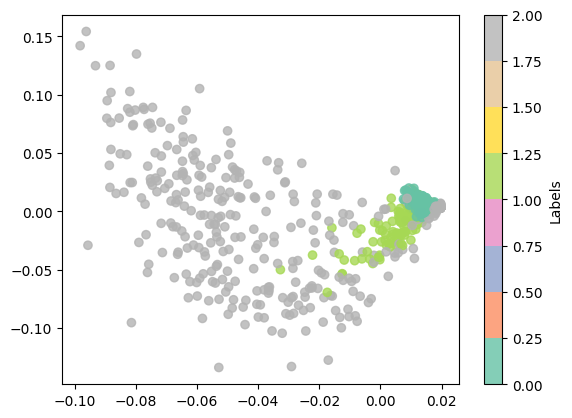

In [ ]:
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=labels["label"].values, cmap="Set2", alpha=0.8
)
plt.colorbar(label="Labels")
plt.show()

In [15]:
# fig = px.scatter_3d(
#     x=embedding[:, 0],
#     y=embedding[:, 1],
#     z=embedding[:, 2],
#     color=labels["label"],
#     labels={'color': 'Label'},
#     title="LLE",
#     color_continuous_scale='viridis'
# )

# fig.update_layout(
#     scene=dict(
#         xaxis_title=f"LLE Component 1",
#         yaxis_title=f"LLE Component 2",
#         zaxis_title=f"LLE Component 3"
#     )
# )

# fig.write_html(f"../../plots/LLE_3d_1200_processed_images_balanced_98_components.html")

In [16]:
labels["label"].value_counts()

label
1    400
0    400
2    400
Name: count, dtype: int64

In [17]:
kmeans = KMeans(n_clusters=3, random_state=SEED, n_init="auto").fit(embedding)
preds = kmeans.predict(embedding)
preds.shape

(1200,)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embedding = scaler.fit_transform(embedding)

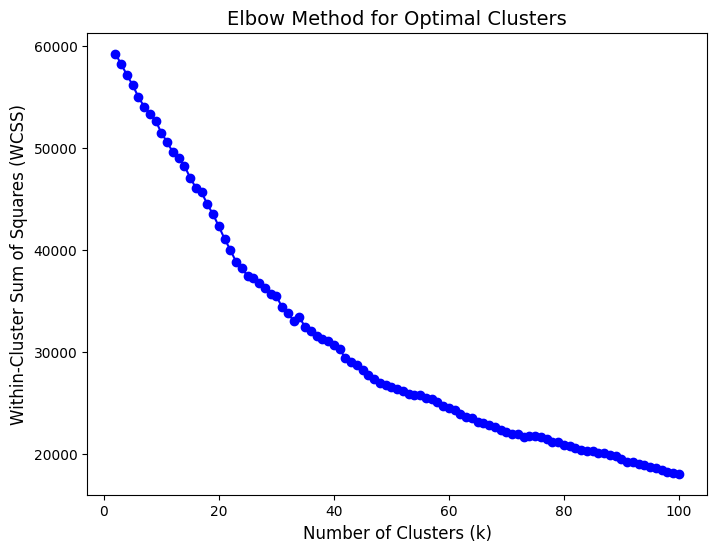

In [ ]:
max_clusters = 100  # Maximum number of clusters to try
wcss = []  # List to store WCSS values


# Loop over different numbers of clusters
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init="auto").fit(
        embedding
    )
    wcss.append(kmeans.inertia_)  # Save the WCSS (inertia)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters + 1), wcss, marker="o", linestyle="-", color="b")
plt.title("Elbow Method for Optimal Clusters", fontsize=14)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Within-Cluster Sum of Squares (WCSS)", fontsize=12)
# plt.xticks(range(2, max_clusters + 1))  # Ensure all k values are marked
# plt.grid(True)
plt.show()

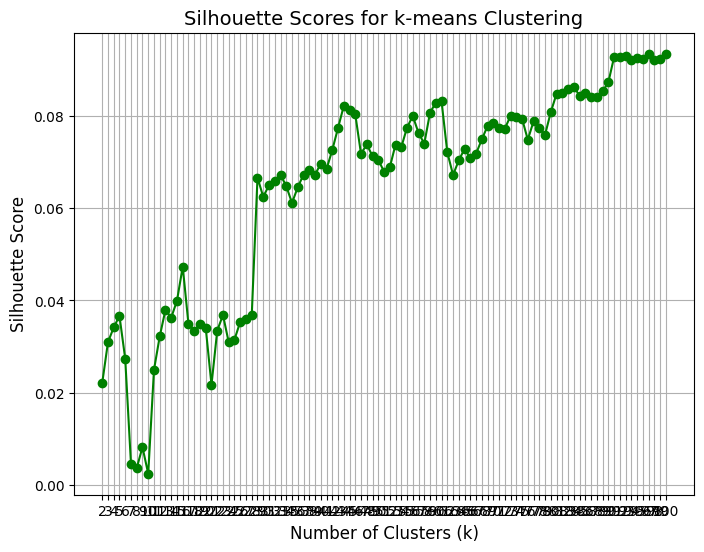

In [ ]:
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init="auto").fit(
        embedding
    )
    score = silhouette_score(embedding, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(
    range(2, max_clusters + 1), silhouette_scores, marker="o", linestyle="-", color="g"
)
plt.title("Silhouette Scores for k-means Clustering", fontsize=14)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.xticks(range(2, max_clusters + 1))
plt.grid(True)
plt.show()

In [ ]:
fig = px.scatter_3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    color=preds,
    labels={"color": "Label"},
    title="LLE",
    color_continuous_scale="viridis",
)

fig.update_layout(
    scene=dict(
        xaxis_title=f"LLE Component 1",
        yaxis_title=f"LLE Component 2",
        zaxis_title=f"LLE Component 3",
    )
)

fig.write_html(
    f"../../plots/kmeans_LLE_3d_2458_processed_canny_images_high_confidence.html"
)